**HOMEWORK**  

The goal of this homework is to create a regression model for predicting the performance of students on a standardized test (column 'JAMB_Score').

You can take it from [Kaggle](https://www.kaggle.com/datasets/idowuadamo/students-performance-in-2024-jamb) or download using wget link mentioned below:

```
wget https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv

```



In [1]:
#@ IMPORTING LIBRARIES AND DEPENDENCIES:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [2]:
import os
import requests
from scipy.stats import shapiro

In [3]:
file_name = 'jamb_exam_results.csv'
url = 'https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv'

if os.path.exists(file_name):
    print(f"{file_name} already exists. Canceling download.")
else:
    response = requests.get(url)
    if response.status_code == 200:
        with open(file_name, 'wb') as f:
            f.write(response.content)
        print(f"{file_name} has been downloaded.")
    else:
        print(f"Failed to download {file_name}. Status code: {response.status_code}")


jamb_exam_results.csv already exists. Canceling download.


In [4]:
#@ READING DATASET:
PATH = "./jamb_exam_results.csv"
df = pd.read_csv(PATH)
#df.total_bedrooms = df.total_bedrooms.fillna(0)

In [5]:
df

,JAMB_Score,Study_Hours_Per_Week,Attendance_Rate,Teacher_Quality,Distance_To_School,School_Type,School_Location,Extra_Tutorials,Access_To_Learning_Materials,Parent_Involvement,IT_Knowledge,Student_ID,Age,Gender,Socioeconomic_Status,Parent_Education_Level,Assignments_Completed
0,192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,1,17,Male,Low,Tertiary,2
1,207,14,88,4,2.7,Public,Rural,No,Yes,High,High,2,15,Male,High,NaN,1
2,182,29,87,2,9.6,Public,Rural,Yes,Yes,High,Medium,3,20,Female,High,Tertiary,2
3,210,29,99,2,2.6,Public,Urban,No,Yes,Medium,High,4,22,Female,Medium,Tertiary,1
4,199,12,98,3,8.8,Public,Urban,No,Yes,Medium,Medium,5,22,Female,Medium,Tertiary,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,183,20,74,2,10.6,Public,Urban,Yes,No,Low,Low,4996,16,Male,Medium,Primary,2
4996,179,0,80,2,20.0,Public,Rural,No,Yes,Medium,Medium,4997,22,Male,Low,Secondary,1
4997,261,17,89,3,11.3,Public,Urban,No,No,Low,High,4998,18,Male,Medium,Primary,3
4998,183,15,96,2,15.9,Public,Rural,No,No,Low,Medium,4999,18,Male,Medium,Secondary,1


In [6]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [7]:
df.columns

Index(['jamb_score', 'study_hours_per_week', 'attendance_rate',
       'teacher_quality', 'distance_to_school', 'school_type',
       'school_location', 'extra_tutorials', 'access_to_learning_materials',
       'parent_involvement', 'it_knowledge', 'student_id', 'age', 'gender',
       'socioeconomic_status', 'parent_education_level',
       'assignments_completed'],
      dtype='object')

In [8]:
df.isna().sum()

jamb_score                        0
study_hours_per_week              0
attendance_rate                   0
teacher_quality                   0
distance_to_school                0
school_type                       0
school_location                   0
extra_tutorials                   0
access_to_learning_materials      0
parent_involvement                0
it_knowledge                      0
student_id                        0
age                               0
gender                            0
socioeconomic_status              0
parent_education_level          891
assignments_completed             0
dtype: int64

- Remove the student_id column.
- Fill missing values with zeros.

In [9]:
# Drop the 'student_id' column
df = df.drop(columns=['student_id'])

# Fill missing values with zeros
df = df.fillna(0)

In [10]:
df.isna().sum()

jamb_score                      0
study_hours_per_week            0
attendance_rate                 0
teacher_quality                 0
distance_to_school              0
school_type                     0
school_location                 0
extra_tutorials                 0
access_to_learning_materials    0
parent_involvement              0
it_knowledge                    0
age                             0
gender                          0
socioeconomic_status            0
parent_education_level          0
assignments_completed           0
dtype: int64

- Do train/validation/test split with 60%/20%/20% distribution.
- Use the train_test_split function and set the random_state parameter to 1.

In [11]:
stat, p = shapiro(df['jamb_score'])
print(f'Statistics={stat}, p-value={p}')

if p > 0.05:
    print("Data follows normal distribution")
else:
    print("Data does not follow normal distribution")

Statistics=0.9676150436531823, p-value=3.955364011000103e-32
Data does not follow normal distribution


In [12]:
#@ SPLITTING THE DATASET FOR TRAINING AND TEST:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

#y_train = np.log1p(df_train.jamb_score.values)
#y_val = np.log1p(df_val.jamb_score.values)
#y_test = np.log1p(df_test.jamb_score.values)

# Store the original jamb_score values
y_train = df_train.jamb_score.values
y_val = df_val.jamb_score.values
y_test = df_test.jamb_score.values

del df_train['jamb_score']
del df_val['jamb_score']
del df_test['jamb_score']

- Use DictVectorizer(sparse=True) to turn the dataframes into matrices.

In [13]:
df.columns

Index(['jamb_score', 'study_hours_per_week', 'attendance_rate',
       'teacher_quality', 'distance_to_school', 'school_type',
       'school_location', 'extra_tutorials', 'access_to_learning_materials',
       'parent_involvement', 'it_knowledge', 'age', 'gender',
       'socioeconomic_status', 'parent_education_level',
       'assignments_completed'],
      dtype='object')

In [14]:
# Initialize features as the current column names
features = df.columns.tolist()

# Remove 'jamb_score' from the features list
features.remove('jamb_score')

In [15]:
train_dicts = df_train[features].to_dict(orient='records')
val_dicts = df_val[features].to_dict(orient='records')

In [16]:
#@ IMPLEMENTATION OF DICTVECTORIZER:
dv = DictVectorizer(sparse=True)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

#@ IMPLEMENTATION OF DICTVECTORIZER:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

**Question 1**

Let's train a decision tree regressor to predict the `jamb_score` variable.

Train a model with `max_depth=1`.

In [17]:
#@ TRAINING THE REGRESSION MODEL:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [18]:
#@ INSPECTION:
print(export_text(dt, feature_names=dv.feature_names_))

|--- study_hours_per_week <= 18.50
|   |--- value: [155.24]
|--- study_hours_per_week >  18.50
|   |--- value: [188.59]



- Which feature is used for splitting the data?

- Answer: `study_hours_per_week`.

**Question 2**

Train a random forest model with these parameters:

- `n_estimators=10`  
- `random_state=1`  
- `n_jobs=-1` (optional-to make training faster)

In [19]:
#@ TRAINING RANDOM FOREST MODEL:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [20]:
#@ CALCULATING MEAN SQUARED ERROR:
y_pred = rf.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_pred))

np.float64(42.13724207871227)

- What's the RMSE of this model on validation?

- Answer: 42.13

**Question 3**

Now, let's experiment with the `n_estimators` parameter.

- Try different values of this parameter from 10 to 200 with step 10.
- Set `random_state` to 1.
- Evaluate the model on the validation dataset.

In [21]:
#@ TRAINING THE RANDOM FOREST MODEL:
scores = []

for n in tqdm(range(10, 201, 10)):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    
    scores.append((n, score))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

  0%|          | 0/20 [00:00<?, ?it/s]

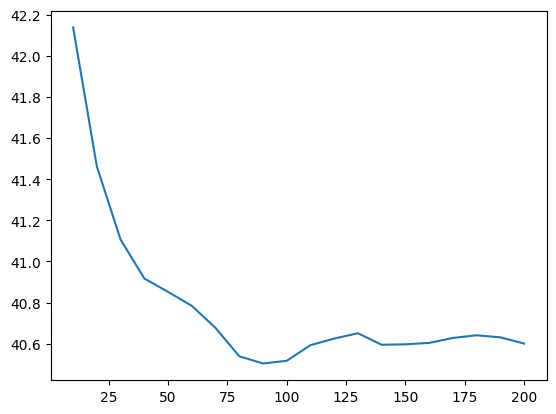

In [22]:
#@ INSPECTING THE RMSE SCORES:
plt.plot(df_scores.n_estimators, df_scores.rmse.round(3))
plt.show()

In [23]:
# Calculate the difference between consecutive RMSE values
df_scores['rmse_diff'] = df_scores.rmse.diff().abs()

# Set a threshold, e.g., 0.01
threshold = 0.05

# Find the first n_estimators where rmse_diff is below the threshold
optimal_n = df_scores[df_scores['rmse_diff'] < threshold]['n_estimators'].iloc[0]
print(f"The RMSE stops improving significantly after n_estimators = {optimal_n}")


The RMSE stops improving significantly after n_estimators = 90


- After which value of `n_estimators` does RMSE stop improving?

- Answer: 80

**Question 4**

Let's select the best `max_depth`:

- Try different values of `max_depth`: [10, 15, 20, 25].
- For each of these values, try different values of n_estimators from 10 till 200 (with step 10).
- Fix the random seed: `random_state=1`.

In [24]:
#@ TRAINING THE MODEL WITH DEPTH:
scores = []

for d in tqdm([10, 15, 20, 25]):
    rf = RandomForestRegressor(n_estimators=0,
                               max_depth=d,
                               random_state=1, n_jobs=-1,
                               warm_start=True)

    for n in tqdm(range(10, 201, 10)):
        rf.n_estimators = n
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))

        scores.append((d, n, score))

columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

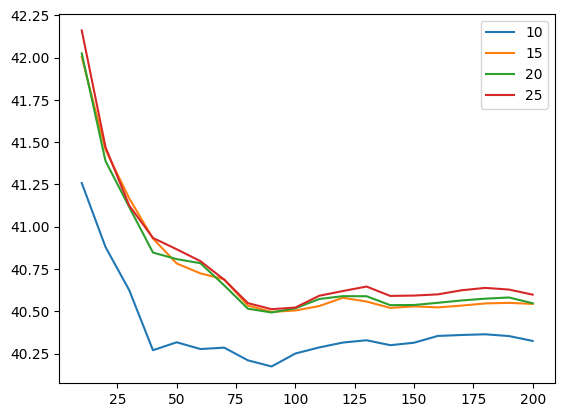

In [25]:
#@ PLOTTING THE GRAPH:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=d)

plt.legend()
plt.show()

In [26]:
# Calculate the mean RMSE for each max_depth
mean_rmse_per_depth = df_scores.groupby('max_depth')['rmse'].mean()

# Find the max_depth with the lowest mean RMSE
best_max_depth = mean_rmse_per_depth.idxmin()
best_rmse = mean_rmse_per_depth.min()

print(f"The best max_depth is {best_max_depth} with a mean RMSE of {best_rmse:.3f}")


The best max_depth is 10 with a mean RMSE of 40.392


- What's the best `max_depth`:

- Answer: 10

**Question 5**

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorith, it finds the best split. When doint it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the imporatant features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field.

For this homework question, we'll find the most important feature:

Train the model with these parametes:
- `n_estimators=10`,
- `max_depth=20`,
- `random_state=1`,
- `n_jobs=-1` (optional)

Get the feature importance information from this model

In [27]:
#@ TRAINING THE RANDOM FOREST MODEL:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, 
                           random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [28]:
#@ INSPECTING FEATURE IMPORTANCE:
rf.feature_importances_

array([0.0123254 , 0.01026189, 0.06931145, 0.03151679, 0.14972903,
       0.1364858 , 0.01345934, 0.00913136, 0.00928871, 0.01038263,
       0.01771934, 0.01240405, 0.00914148, 0.        , 0.01545036,
       0.01695692, 0.01448862, 0.02291885, 0.01335761, 0.01149201,
       0.00955909, 0.00923932, 0.0089532 , 0.00840598, 0.02571426,
       0.01070798, 0.01056268, 0.24835361, 0.08268222])

In [29]:
#@ INSPECTING FEATURE IMPORTANCES:
df_importances = pd.DataFrame()
df_importances['feature'] = dv.feature_names_
df_importances['importance'] = rf.feature_importances_
df_importances

,feature,importance
0,access_to_learning_materials=No,0.012325
1,access_to_learning_materials=Yes,0.010262
2,age,0.069311
3,assignments_completed,0.031517
4,attendance_rate,0.149729
5,distance_to_school,0.136486
6,extra_tutorials=No,0.013459
7,extra_tutorials=Yes,0.009131
8,gender=Female,0.009289
9,gender=Male,0.010383


In [30]:
#@ SORTING THE VALUES:
df_importances.sort_values(by='importance', ascending=False).head()

,feature,importance
27,study_hours_per_week,0.248354
4,attendance_rate,0.149729
5,distance_to_school,0.136486
28,teacher_quality,0.082682
2,age,0.069311


- What's the most important feature?

- Answer: `study_hours_per_week`.

**Question 6**

Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

- Install XGBoost.
- Create DMatrix for train and validation
- Create a watchlist
- Train a model with these parameters for 100 rounds:

```
xgb_params = {  
    'eta': 0.3,  
    'max_depth': 6,  
    'min_child_weight': 1,  

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}
```



In [31]:
#@ CREATING THE DMARTIX:
features = dv.feature_names_

regex = re.compile(r"<", re.IGNORECASE)
features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [32]:
#@ INITIALIZATION:
watchlist = [(dtrain, 'train'), (dval, 'val')]
scores = {}

In [33]:
#@ DEFINING THE FUNCTION:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [34]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [35]:
#@ STORING:
scores['eta=0.3'] = parse_xgb_output(output)

Now change eta from 0.3 to 0.1.

In [36]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [37]:
#@ STORING:
scores['eta=0.1'] = parse_xgb_output(output)

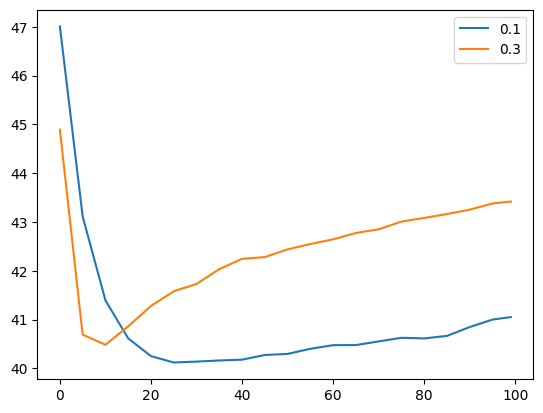

In [38]:
#@ INSPECTION:
plt.plot(scores['eta=0.1'].num_iter, scores['eta=0.1'].val_auc,
        label='0.1')
plt.plot(scores['eta=0.3'].num_iter, scores['eta=0.3'].val_auc,
        label='0.3')
plt.legend()
plt.show()

In [39]:
# Extract minimum validation RMSE for each eta
best_rmse_eta_0_1 = scores['eta=0.1'].val_auc.min()
best_rmse_eta_0_3 = scores['eta=0.3'].val_auc.min()

# Print and compare
print(f"Best RMSE for eta=0.1: {best_rmse_eta_0_1:.4f}")
print(f"Best RMSE for eta=0.3: {best_rmse_eta_0_3:.4f}")

# Determine which eta has the best RMSE
if best_rmse_eta_0_1 < best_rmse_eta_0_3:
    print("Eta=0.1 provides the best RMSE on the validation dataset.")
else:
    print("Eta=0.3 provides the best RMSE on the validation dataset.")


Best RMSE for eta=0.1: 40.1200
Best RMSE for eta=0.3: 40.4832
Eta=0.1 provides the best RMSE on the validation dataset.


- Which eta leads to the best RMSE score on the validation dataset?

- Answer: 0.1